In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import re
from scipy.interpolate import griddata
import json

# ============================================================================
# BLOCK 1: Extract params, loss, and grad from file
# ============================================================================

n_pts = "200"

# filename = "C:\\Users\\Experiment\\OneDrive - The University of Queensland\\Desktop\\SF_COMSOL\\notebooks\\2d_sweep\\10-10-25.dat"
# if n_pts:
#     filename = f"C:\\Users\\Experiment\\OneDrive - The University of Queensland\\Desktop\\SF_COMSOL\\notebooks\\n_vs_grad\\data\\{n_pts}pts.dat"

if n_pts:
    filename = f"C:\\Users\\Experiment\\OneDrive - The University of Queensland\\Desktop\\SF_COMSOL\\notebooks\\experiments\\exp_20251015_202152\\sweep_pure_epr_{n_pts}_20251015-2021-52.jsonl"


# Scaling factor for gradients from file (adjustable)
GRAD_SCALING_FACTOR = 0.0000002

params_list         = []
total_loss_list     = []
loss_epr_list       = []
grad_epr_list       = []

with open(filename, 'r') as f:
    data = [json.loads(line) for line in f if line.strip()]

print(len(data))

print(data[0])
params_array     = np.array([d["params"]               for d in data], dtype=float)      # (N, 2)
loss_total = np.array([d["loss"]                 for d in data], dtype=float)      # (N,)
loss_epr   = np.array([d.get("loss_epr", np.nan) for d in data], dtype=float)      # (N,)
grad_epr   = np.array([d.get("grad_epr", [np.nan, np.nan]) for d in data], dtype=float)  # (N,2)


225
{'params': [0.18, 0.24], 'loss': -5.873163977453228e+18, 'grad': [2.9154472603905822e+20, 1.0468297419590616e+21], 'loss_jj': 0, 'loss_epr': -5.873163977453228e+18, 'grad_jj': 0, 'grad_epr': [2.9154472603905822e+20, 1.0468297419590616e+21]}


In [41]:
# ============================================================================
# BLOCK 2: Numerically calculate gradients using forward finite difference
# ============================================================================

# Choose which loss to differentiate
loss_array = loss_epr          # or: loss_total
grad_array = grad_epr          # file-provided gradients for comparison

x_vals = np.unique(params_array[:, 0])
y_vals = np.unique(params_array[:, 1])
print(f"\nGrid dimensions: {len(x_vals)} x {len(y_vals)}")

def key(x, y, prec=12):
    return (round(float(x), prec), round(float(y), prec))

# Fast lookup: (x,y) -> (loss, index)
data_dict = {
    key(px, py): (lv, i)
    for i, ((px, py), lv) in enumerate(zip(params_array, loss_array))
}

numeric_grad_list = []
valid_indices = []

for i, (x, y) in enumerate(params_array):
    # find forward neighbors along each axis
    x_nexts = x_vals[x_vals > x]
    y_nexts = y_vals[y_vals > y]
    if x_nexts.size == 0 or y_nexts.size == 0:
        continue
    x_next = x_nexts[0]
    y_next = y_nexts[0]

    k_c = key(x, y)
    k_x = key(x_next, y)
    k_y = key(x, y_next)

    if k_c in data_dict and k_x in data_dict and k_y in data_dict:
        loss_c = data_dict[k_c][0]
        loss_x = data_dict[k_x][0]
        loss_y = data_dict[k_y][0]

        dx = x_next - x
        dy = y_next - y

        grad_x = (loss_x - loss_c) / dx
        grad_y = (loss_y - loss_c) / dy

        numeric_grad_list.append([grad_x, grad_y])
        valid_indices.append(i)

numeric_grad_array = np.array(numeric_grad_list)
valid_params      = params_array[valid_indices]
valid_loss        = loss_array[valid_indices]
valid_grad_file   = grad_array[valid_indices]

print(f"Computed {numeric_grad_array.shape[0]} numerical gradients")



Grid dimensions: 15 x 15
Computed 196 numerical gradients


In [42]:
print(len(numeric_grad_array))
print(len(valid_params))
print(len(valid_loss))
print(len(valid_grad_file))

196
196
196
196


In [43]:
# ============================================================================
# BLOCK 3: Compute magnitudes
# ============================================================================

# Magnitude of all file gradients
grad_file_magnitude = np.linalg.norm(grad_array, axis=1)

# Magnitude of numerical gradients (only for valid indices)
grad_numeric_magnitude = np.linalg.norm(numeric_grad_array, axis=1)

print(f"\nFile gradient magnitude range: [{grad_file_magnitude.min():.2e}, {grad_file_magnitude.max():.2e}]")
print(f"Numeric gradient magnitude range: [{grad_numeric_magnitude.min():.2e}, {grad_numeric_magnitude.max():.2e}]")



File gradient magnitude range: [5.66e+20, 1.93e+24]
Numeric gradient magnitude range: [4.14e+19, 8.69e+21]


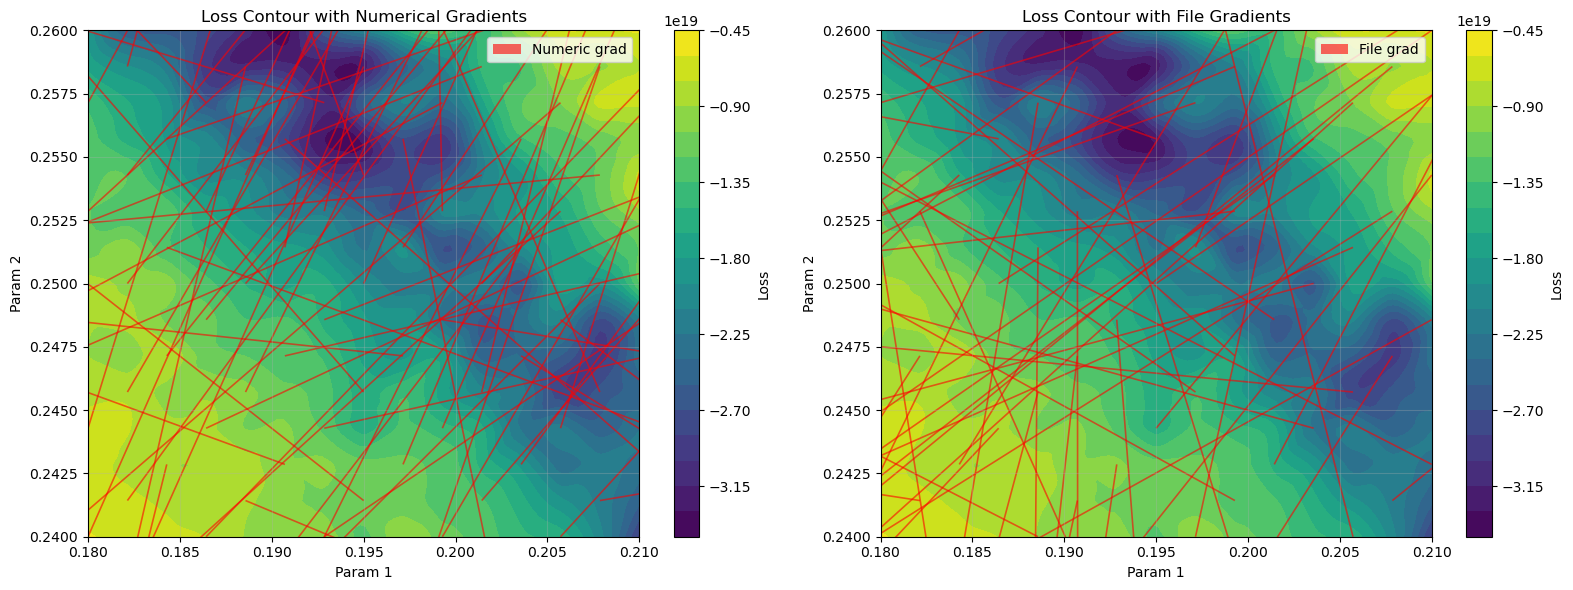

In [44]:
# ============================================================================
# BLOCK 4 & 5: Contour plots
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# Create a finer grid for interpolation
xi = np.linspace(params_array[:, 0].min(), params_array[:, 0].max(), 100)
yi = np.linspace(params_array[:, 1].min(), params_array[:, 1].max(), 100)
Xi, Yi = np.meshgrid(xi, yi)
# Interpolate loss values
Zi = griddata(params_array, loss_array, (Xi, Yi), method='cubic')
# Plot 1: Numerical gradients
ax1 = axes[0]
contour1 = ax1.contourf(Xi, Yi, Zi, levels=20, cmap='viridis')
plt.colorbar(contour1, ax=ax1, label='Loss')
# Plot numerical gradient vectors (subsample for clarity) - NEGATIVE
skip = max(1, len(valid_params) // 50)  # Show ~50 arrows
ax1.quiver(valid_params[::skip, 0], valid_params[::skip, 1],
           -numeric_grad_array[::skip, 0], -numeric_grad_array[::skip, 1],
           color='red', alpha=0.6, scale=1e19, width=0.003,
           label='Numeric grad')
ax1.set_xlabel('Param 1')
ax1.set_ylabel('Param 2')
ax1.set_title('Loss Contour with Numerical Gradients')
ax1.legend()
ax1.grid(True, alpha=0.3)
# Plot 2: File gradients
ax2 = axes[1]
contour2 = ax2.contourf(Xi, Yi, Zi, levels=20, cmap='viridis')
plt.colorbar(contour2, ax=ax2, label='Loss')
# Plot file gradient vectors (subsample for clarity) - NEGATIVE
skip = max(1, len(params_array) // 50)  # Show ~50 arrows
ax2.quiver(params_array[::skip, 0], params_array[::skip, 1],
           -grad_array[::skip, 0], -grad_array[::skip, 1],
           color='red', alpha=0.6, scale=1e19, width=0.003,
           label='File grad')
ax2.set_xlabel('Param 1')
ax2.set_ylabel('Param 2')
ax2.set_title('Loss Contour with File Gradients')
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.tight_layout()
if n_pts:
    plt.savefig(f'{n_pts}_pts_gradient_comparison_contours.png', dpi=150, bbox_inches='tight')
else:
    plt.savefig('gradient_comparison_contours.png', dpi=150, bbox_inches='tight')
plt.show()

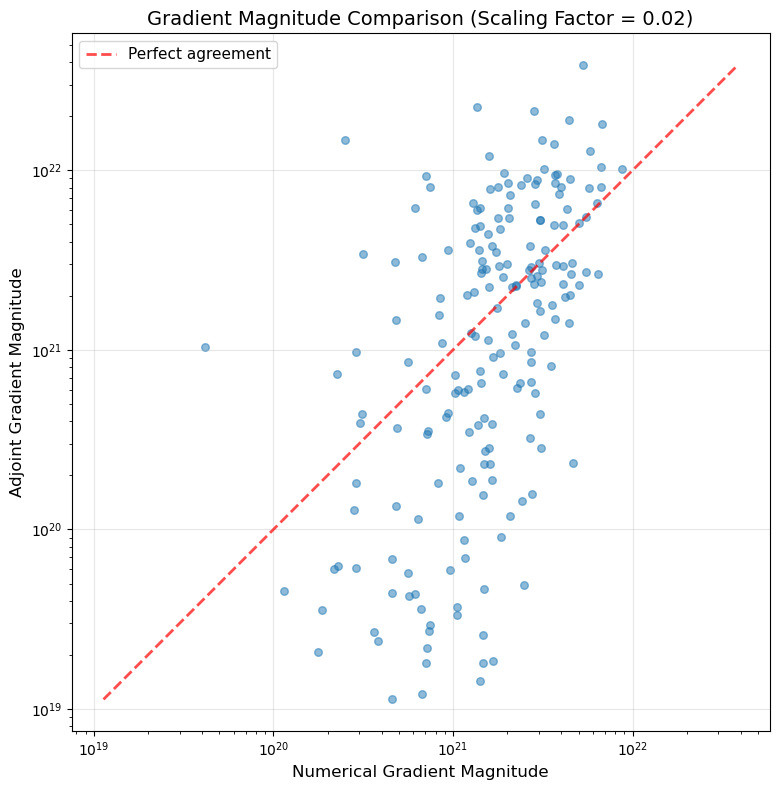

In [45]:

# ============================================================================
# BLOCK 6: Compare gradient magnitudes
# ============================================================================
# GRAD_SCALING_FACTOR = 0.009719030144849967
GRAD_SCALING_FACTOR = 0.02
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(grad_numeric_magnitude, 
           np.linalg.norm(valid_grad_file, axis=1) * GRAD_SCALING_FACTOR,
           alpha=0.5, s=30)

# Add diagonal line for reference (perfect agreement)
max_val = max(grad_numeric_magnitude.max(), 
              np.linalg.norm(valid_grad_file * GRAD_SCALING_FACTOR, axis=1).max())
min_val = min(grad_numeric_magnitude.min(), 
              np.linalg.norm(valid_grad_file * GRAD_SCALING_FACTOR, axis=1).min())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, 
        label='Perfect agreement', alpha=0.7)

ax.set_xlabel('Numerical Gradient Magnitude', fontsize=12)
ax.set_ylabel('Adjoint Gradient Magnitude', fontsize=12)
ax.set_title(f'Gradient Magnitude Comparison (Scaling Factor = {GRAD_SCALING_FACTOR})', 
             fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal', adjustable='box')

# Log scale might be useful given the large numbers

ax.set_xscale('log')
ax.set_yscale('log')

plt.tight_layout()
if n_pts:
    plt.savefig(f'{n_pts}_pts_gradient_magnitude_comparison.png', dpi=150, bbox_inches='tight')
else:
        plt.savefig('gradient_magnitude_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

In [46]:
adjoint_mag = np.linalg.norm(valid_grad_file, axis=1)
numeric_mag = grad_numeric_magnitude

scaling = (adjoint_mag @ numeric_mag) / ( adjoint_mag @ adjoint_mag)
print(scaling)

0.006077362414847816


In [47]:
# ============================================================================
# Summary statistics
# ============================================================================

print("\n" + "="*70)
print("SUMMARY STATISTICS")
print("="*70)

# Correlation between magnitudes
correlation = np.corrcoef(grad_numeric_magnitude, 
                          np.linalg.norm(valid_grad_file, axis=1))[0, 1]
print(f"\nCorrelation between gradient magnitudes: {correlation:.4f}")

# Ratio of magnitudes
ratio = np.linalg.norm(valid_grad_file, axis=1) / grad_numeric_magnitude
print(f"\nRatio statistics (File/Numeric):")
print(f"  Mean: {ratio.mean():.4f}")
print(f"  Median: {np.median(ratio):.4f}")
print(f"  Std: {ratio.std():.4f}")

print("\nTo adjust gradient scaling, modify GRAD_SCALING_FACTOR at the top of the script.")
print("="*70)


SUMMARY STATISTICS

Correlation between gradient magnitudes: 0.4440

Ratio statistics (File/Numeric):
  Mean: 101.2239
  Median: 38.0027
  Std: 249.8422

To adjust gradient scaling, modify GRAD_SCALING_FACTOR at the top of the script.
